# LeNet5 on MNIST
In this lab we will train a LeNet5 model on the MNIST dataset

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import time

It is recommended to use the GPU for this exercise

In [2]:

use_cuda = True

if use_cuda and torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

device

device(type='cuda')

Define a function to show images

In [3]:

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# Function to show an image tensor
def show(X):
    if X.dim() == 3 and X.size(2) == 3:
        plt.imshow(X.numpy())
        plt.show()
    elif X.dim() == 2:
        plt.imshow(   X.numpy() , cmap='gray'  )
        plt.show()
    else:
        print('WRONG TENSOR SIZE')

### Load the MNIST dataset

In [5]:
import torchvision.datasets
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,)),  # Normalize the dataset by subtracting the mean (0.1307) and dividing by the std (0.3081)
                                ])

trainset = torchvision.datasets.MNIST(root='./data_mnist',
                                      train=True,
                                      download=True,
                                      transform=transform
                                      )

testset = torchvision.datasets.MNIST(root='./data_mnist',
                                     train=False,
                                     download=True,
                                     transform=transform
                                     )

batch_size = 80

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          )

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=batch_size,
                                         shuffle=True,
                                         )


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 501kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.66MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.88MB/s]


### Define the LeNet5 architecture

In [13]:
class LeNet5_convnet(nn.Module):

    def __init__(self):

        super(LeNet5_convnet, self).__init__()

        # Conv Layer 1:   28 x 28  -->    50 x 28 x 28
        self.conv1 = nn.Conv2d(1, 50, kernel_size=3, padding=1)

        # Max Pool 1: 50 x 28 x 28 -->    50 x 14 x 14
        self.pool1  = nn.MaxPool2d(2,2)

        # CL2:   50 x 14 x 14  -->    100 x 14 x 14
        self.conv2 = nn.Conv2d(50, 100, kernel_size=3, padding=1) # COMPLETE HERE

        # MP2: 100 x 14 x 14 -->    100 x 7 x 7
        self.pool2 = nn.MaxPool2d(2,2)

        # LL1:   100 x 7 x 7 = 4900 -->  100
        self.linear1 = nn.Linear(in_features=4900, out_features=100)

        # LL2:   100  -->  10
        self.linear2 = nn.Linear(in_features=100, out_features=10)


    def forward(self, x):

        # CL1:   28 x 28  -->    50 x 28 x 28
        x = self.conv1(x)
        x = F.relu(x)

        # MP1: 50 x 28 x 28 -->    50 x 14 x 14
        x = self.pool1(x)

        # CL2:   50 x 14 x 14  -->    100 x 14 x 14
        x = self.conv2(x)
        x = F.relu(x)

        # MP2: 100 x 14 x 14 -->    100 x 7 x 7
        x = self.pool2(x)

        # LL1:   100 x 7 x 7 = 4900  -->  100
        x = x.view(-1, 4900)
        x = self.linear1(x) # COMPLETE HERE -- recall that you need to flatten the data before you can pass it to the dense layer!

        # LL2:   100  -->  10
        x = self.linear2(x)

        return x

In [14]:
# Build the network and move its parameters to either GPU or CPU
net = LeNet5_convnet()
net.to(device='cuda')

LeNet5_convnet(
  (conv1): Conv2d(1, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=4900, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=10, bias=True)
)

### Choose a loss function and learning rate

In [15]:
criterion = nn.CrossEntropyLoss()

my_lr = 0.01


### Train the model on the train set

In [16]:
start=time.time()

optimizer=torch.optim.SGD(net.parameters(), lr=my_lr)

for epoch in range(1,10):

  for i, (x_batch, y_batch) in enumerate(trainloader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move the data to the device that is used

    optimizer.zero_grad()  # Set all currenly stored gradients to zero

    y_pred = net(x_batch)

    loss = criterion(y_pred, y_batch)

    loss.backward()

    optimizer.step()

    # Compute relevant metrics

    y_pred_max = torch.argmax(y_pred, dim=1)  # Get the labels with highest output probability

    correct = torch.sum(torch.eq(y_pred_max, y_batch)).item()  # Count how many are equal to the true labels

    elapsed = time.time() - start  # Keep track of how much time has elapsed

    # Show progress every 20 batches
    if not i % 20:
      print(f'epoch: {epoch}, time: {elapsed:.3f}s, loss: {loss.item():.3f}, train accuracy: {correct / batch_size:.3f}')



epoch: 1, time: 1.146s, loss: 2.313, train accuracy: 0.075
epoch: 1, time: 1.559s, loss: 1.894, train accuracy: 0.550
epoch: 1, time: 1.940s, loss: 1.234, train accuracy: 0.675
epoch: 1, time: 2.325s, loss: 0.848, train accuracy: 0.787
epoch: 1, time: 2.698s, loss: 0.719, train accuracy: 0.775
epoch: 1, time: 3.089s, loss: 0.523, train accuracy: 0.800
epoch: 1, time: 3.493s, loss: 0.425, train accuracy: 0.850
epoch: 1, time: 3.874s, loss: 0.669, train accuracy: 0.775
epoch: 1, time: 4.266s, loss: 0.437, train accuracy: 0.887
epoch: 1, time: 4.786s, loss: 0.467, train accuracy: 0.863
epoch: 1, time: 5.283s, loss: 0.379, train accuracy: 0.925
epoch: 1, time: 5.783s, loss: 0.263, train accuracy: 0.900
epoch: 1, time: 6.339s, loss: 0.380, train accuracy: 0.900
epoch: 1, time: 6.708s, loss: 0.188, train accuracy: 0.975
epoch: 1, time: 7.080s, loss: 0.487, train accuracy: 0.875
epoch: 1, time: 7.465s, loss: 0.249, train accuracy: 0.912
epoch: 1, time: 7.839s, loss: 0.237, train accuracy: 0.9

### Evaluate the model on the test set

In [17]:
correct_total = 0

for i, (x_batch, y_batch) in enumerate(testloader):
  x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move the data to the device that is used

  y_pred = net(x_batch)
  y_pred_max = torch.argmax(y_pred, dim=1)

  correct_total += torch.sum(torch.eq(y_pred_max, y_batch)).item()

print(f'Accuracy on the test set: {correct_total / len(testset):.3f}')

Accuracy on the test set: 0.981


### Show the model's prediction for a random sample from the test set

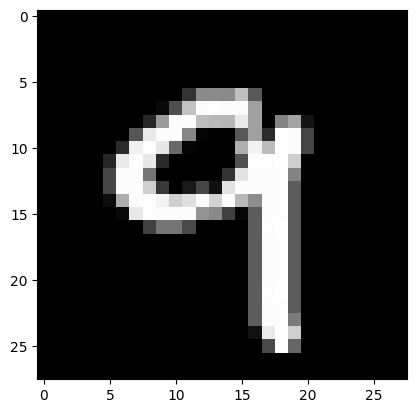

Confidence scores:
0: 3.6136904579819884e-10
1: 7.347520813993924e-09
2: 8.656170225052051e-10
3: 4.740766144095687e-06
4: 6.940841558389366e-05
5: 3.174843641318148e-07
6: 3.639633299606926e-12
7: 0.0002999534481205046
8: 3.2456462122354424e-06
9: 0.9996223449707031

Label with highest confidence score: 9


In [24]:
# choose a picture at random
im_minibatch, label_minibatch = next(iter(testloader))
im, label = im_minibatch[0].cpu(), label_minibatch[0].cpu()

# diplay the picture
show(im.squeeze())

# feed it to the net and display the confidence scores
prob = F.softmax(net.cpu()(im.unsqueeze(0)), dim=1)

print('Confidence scores:\n' + '\n'.join(['{}: {}'.format(i, p.item()) for i, p in enumerate(prob.squeeze())]))

print('\nLabel with highest confidence score: {}'.format(torch.argmax(prob).item()))